In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import gymnasium as gym

from astropy.io import fits
from datetime import datetime
import json
import fitsio
import pandas as pd
import time
import pickle

%reload_ext autoreload
%autoreload 2

In [2]:
import survey_ops
from survey_ops.utils import units, geometry, interpolate
from survey_ops.src.offline_dataset import OfflineDECamDataset
from survey_ops.src.agents import Agent
from survey_ops.src.algorithms import DDQN, BehaviorCloning
from survey_ops.utils.pytorch_utils import seed_everything


In [3]:
seed_everything(10)

# Load and cut data from fits file, save as .json

In [4]:
data_json_fn = '../data/data.json'
data_fits_fn = '../data/decam-exposures-20251107.fits.gz'

try:
    # --- Load json df ---- #
    df = pd.read_json(data_json_fn)
    print('Loaded data from json')
except:
    # --- Load fits ---- #
    print(data_json_fn, 'DNE. Loading and processing data from fits.')
    d = fitsio.read('../data/decam-exposures-20251107.fits.gz')
    sel = (d['propid'] == '2012B-0001') & (d['exptime'] > 40) & (d['exptime'] < 100) & (~np.isnan(d['teff']))
    selected_d = d[sel]
    column_names = selected_d.dtype.names
    df = pd.DataFrame(selected_d, columns=column_names)
    print(df['datetime'].dtype)
    
    # mask = np.array([False if 'None' in dt else True for dt in subs_data['datetime']])
    # subs_data = {key: subs_data[key][mask] for key in subs_data.keys()}
    
    df.to_json(data_json_fn, indent=2)
    df = pd.read_json(data_json_fn)
    

Loaded data from json


# Instantiate the offline dataset choosing number of bins for (az,el)

## You can get the data/transitions for the entire dataset in the dataframe

In [6]:
num_bins_1d = 19

dataset = OfflineDECamDataset(
    df, 
    num_bins_1d=num_bins_1d, 
    normalize_state=True,
    binning_method='uniform_grid',
    bin_space='azel'
) #specific_years=[2013,2014])

In [7]:
first_obs_in_night_indices = []
for key, indices in dataset._groups.indices.items():
    first_obs_in_night_indices.append(indices[0])

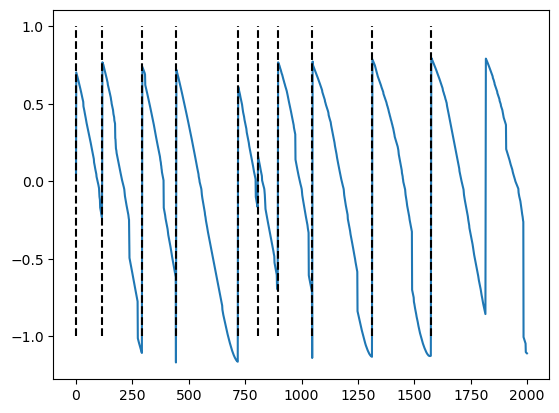

In [15]:
stop = 2000
plt.plot((dataset.states * dataset.stds + dataset.means)[:, dataset.statename2idx['sun_el']][:stop])
plt.vlines(first_obs_in_night_indices[:10], ymin=-1., ymax=1., linestyle='--', color='black')

In [16]:
dataset._df.columns

Index(['expnum', 'ra', 'dec', 'exptime', 'filter', 'propid', 'program', 'teff',
       'fwhm', 'datetime', 'az', 'zd', 'ha', 'airmass', 'qc_fwhm', 'qc_cloud',
       'qc_sky', 'qc_teff', 'timestamp', 'night'],
      dtype='object')

In [17]:
T_obs = []
for day, subdf in dataset._groups:
    timestamps = subdf['timestamp'].values
    T_obs.append(timestamps[-1] - timestamps[0])


In [18]:
T_obs = np.array(T_obs)/60/60

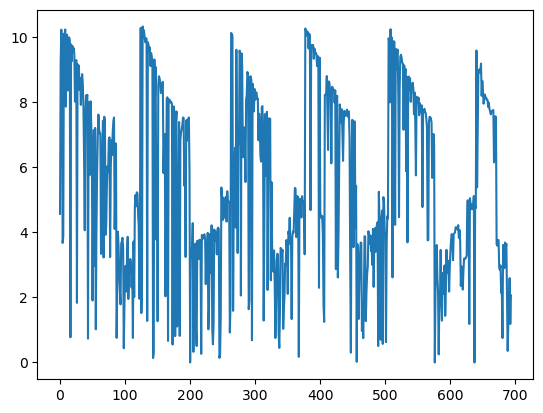

In [19]:
plt.plot(T_obs)

## You can also specify years, months, days, and filters to get a smaller subset of transitions

# Configure model, data selection, and training setup

In [26]:
SEED = 10
seed_everything(SEED)
torch.set_default_dtype(torch.float32)
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

In [28]:
num_bins_1d = 19
dataset = OfflineDECamDataset(
    df, 
    num_bins_1d=19, 
    binning_method='uniform_grid',
    bin_space='azel',
    normalize_state=True,
    specific_years=[2013],
    specific_months=[8],
    # specific_days=np.arange(2, 4),
    # specific_filters=['r', 'g']
)

In [29]:
batch_size = 32
num_workers = 4
pin_memory = True if device == 'cuda' else False
trainloader = dataset.get_dataloader(batch_size, num_workers = num_workers, pin_memory = pin_memory)


In [30]:
"""Algorithm and Train setup"""

alg_config = {
    'obs_dim': dataset.obs_dim,
    'num_actions': dataset.num_actions,
    'hidden_dim': 64,
    'device': device,
    'lr': 3e-3,
    'loss_fxn': None, #torch.nn.cross_entropy,
    # 'use_double': True,
}
alg = BehaviorCloning(**alg_config)

fit_config = {
    'num_epochs' : 100,
    'batch_size': batch_size,
    # 'learning_start': 
    }

env_name = 'TelescopeEnv-v0'

def create_exp_name(alg, env_name, dataset, fit_config, alg_config):
    exp_name = f"{alg.name}"
    exp_name += f"-{env_name}"
    exp_name += f"-n_nights={dataset.n_nights}"
    # config_prefix += f"-use_double={alg_config['use_double']}"
    exp_name += f"-num_epochs={fit_config['num_epochs']}"
    exp_name += f"-batch_size={fit_config['batch_size']}"
    exp_name += f"-lr={alg_config['lr']}"
    return exp_name

exp_name = create_exp_name(alg, env_name, dataset, fit_config, alg_config)

outdir = f'../results/{exp_name}/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
fig_outdir = outdir + 'figures/'
if not os.path.exists(fig_outdir):
    os.makedirs(fig_outdir)

agent_config = {
    'algorithm': alg,
    'normalize_obs': dataset.normalize_state,
    'outdir': outdir
    }

agent = Agent(**agent_config)



# Visualize dataset in (az, el) and binning sizes

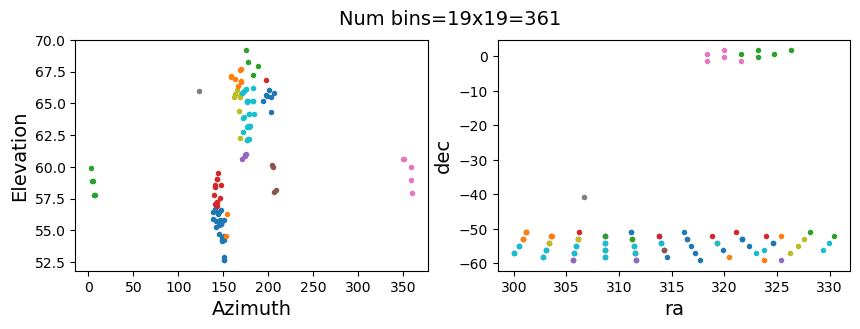

In [31]:
s = 1000/len(dataset)
fig, axs = plt.subplots(1,2, figsize=(10,3))
for bin_id in dataset.id2azel.keys():
    field_ids = np.array(dataset.id2azel[bin_id])
    axs[0].scatter(field_ids[:, 0], field_ids[:, 1], label='bin' + str(bin_id), s=s)
axs[0].set_xlabel('Azimuth', fontsize=14)
axs[0].set_ylabel('Elevation', fontsize=14)

for bin_id in dataset.id2radec.keys():
    field_ids = np.array(dataset.id2radec[bin_id])
    axs[1].scatter(field_ids[:, 0], field_ids[:, 1], label='bin' + str(bin_id), s=s)
axs[1].set_xlabel('ra', fontsize=14)
axs[1].set_ylabel('dec', fontsize=14)

fig.suptitle(f'Num bins={num_bins_1d}x{num_bins_1d}={dataset.num_actions}', fontsize=14)
fig.savefig(fig_outdir + 'plot_observations_in_sky_colored_bins.png')

# Train

In [32]:
start_time = time.time()
"""Train"""
agent.fit(
    dataloader=trainloader,
    **fit_config
    )
end_time = time.time()
train_time = end_time - start_time
print(f'Total train time = {train_time}s')

  0%|                                                 | 0/11600 [00:00<?, ?it/s]/home/hurra/Projects/survey-ops/survey_ops/src/agents.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eval_obs = torch.tensor(eval_obs, device=self.device)
/home/hurra/Projects/survey-ops/survey_ops/src/agents.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expert_actions = torch.tensor(expert_actions, device=self.device)
  1%|▍                                     | 116/11600 [00:00<00:20, 551.10it/s]

Train step 0: Accuracy = 0.000, Loss = 5.8657, Q-val=0.000
Train step 100: Accuracy = 0.469, Loss = 1.4253, Q-val=0.000
Train step 200: Accuracy = 0.656, Loss = 0.7899, Q-val=0.000


  4%|█▌                                    | 462/11600 [00:00<00:11, 995.03it/s]

Train step 300: Accuracy = 0.781, Loss = 0.7618, Q-val=0.000
Train step 400: Accuracy = 0.625, Loss = 0.7218, Q-val=0.000
Train step 500: Accuracy = 0.531, Loss = 0.6416, Q-val=0.000


  7%|██▋                                  | 834/11600 [00:00<00:09, 1160.81it/s]

Train step 600: Accuracy = 0.625, Loss = 0.8363, Q-val=0.000
Train step 700: Accuracy = 0.750, Loss = 0.6069, Q-val=0.000
Train step 800: Accuracy = 0.750, Loss = 0.6315, Q-val=0.000


  9%|███▎                                | 1082/11600 [00:01<00:08, 1200.69it/s]

Train step 900: Accuracy = 0.844, Loss = 0.3571, Q-val=0.000
Train step 1000: Accuracy = 0.781, Loss = 0.6472, Q-val=0.000
Train step 1100: Accuracy = 0.625, Loss = 0.4416, Q-val=0.000


 11%|████                                | 1325/11600 [00:01<00:08, 1195.97it/s]

Train step 1200: Accuracy = 0.656, Loss = 0.3239, Q-val=0.000
Train step 1300: Accuracy = 0.750, Loss = 0.4652, Q-val=0.000
Train step 1400: Accuracy = 0.875, Loss = 0.4447, Q-val=0.000


 15%|█████▏                              | 1684/11600 [00:01<00:08, 1163.65it/s]

Train step 1500: Accuracy = 0.781, Loss = 0.2657, Q-val=0.000
Train step 1600: Accuracy = 0.812, Loss = 0.1929, Q-val=0.000
Train step 1700: Accuracy = 0.906, Loss = 0.2986, Q-val=0.000


 17%|█████▉                              | 1921/11600 [00:01<00:08, 1169.54it/s]

Train step 1800: Accuracy = 0.875, Loss = 0.2556, Q-val=0.000
Train step 1900: Accuracy = 0.875, Loss = 0.2251, Q-val=0.000
Train step 2000: Accuracy = 0.844, Loss = 0.1924, Q-val=0.000


 20%|███████                             | 2283/11600 [00:02<00:07, 1190.12it/s]

Train step 2100: Accuracy = 0.969, Loss = 0.1300, Q-val=0.000
Train step 2200: Accuracy = 0.969, Loss = 0.2887, Q-val=0.000
Train step 2300: Accuracy = 0.906, Loss = 0.2407, Q-val=0.000


 22%|███████▊                            | 2529/11600 [00:02<00:07, 1211.58it/s]

Train step 2400: Accuracy = 0.906, Loss = 0.1234, Q-val=0.000
Train step 2500: Accuracy = 0.938, Loss = 0.2840, Q-val=0.000
Train step 2600: Accuracy = 0.875, Loss = 0.0980, Q-val=0.000


 25%|████████▉                           | 2895/11600 [00:02<00:07, 1191.91it/s]

Train step 2700: Accuracy = 1.000, Loss = 0.1281, Q-val=0.000
Train step 2800: Accuracy = 0.969, Loss = 0.1964, Q-val=0.000
Train step 2900: Accuracy = 1.000, Loss = 0.1780, Q-val=0.000


 27%|█████████▋                          | 3138/11600 [00:02<00:07, 1192.09it/s]

Train step 3000: Accuracy = 0.906, Loss = 0.1681, Q-val=0.000
Train step 3100: Accuracy = 0.969, Loss = 0.1893, Q-val=0.000
Train step 3200: Accuracy = 0.969, Loss = 0.2408, Q-val=0.000


 30%|██████████▉                         | 3505/11600 [00:03<00:06, 1205.41it/s]

Train step 3300: Accuracy = 1.000, Loss = 0.0561, Q-val=0.000
Train step 3400: Accuracy = 0.875, Loss = 0.0826, Q-val=0.000
Train step 3500: Accuracy = 0.906, Loss = 0.1234, Q-val=0.000


 32%|███████████▋                        | 3746/11600 [00:03<00:06, 1191.59it/s]

Train step 3600: Accuracy = 0.969, Loss = 0.1290, Q-val=0.000
Train step 3700: Accuracy = 1.000, Loss = 0.1582, Q-val=0.000
Train step 3800: Accuracy = 1.000, Loss = 0.0905, Q-val=0.000


 35%|████████████▊                       | 4116/11600 [00:03<00:06, 1215.41it/s]

Train step 3900: Accuracy = 0.938, Loss = 0.1005, Q-val=0.000
Train step 4000: Accuracy = 0.969, Loss = 0.1242, Q-val=0.000
Train step 4100: Accuracy = 0.906, Loss = 0.0758, Q-val=0.000


 38%|█████████████▌                      | 4368/11600 [00:03<00:05, 1236.40it/s]

Train step 4200: Accuracy = 0.969, Loss = 0.1197, Q-val=0.000
Train step 4300: Accuracy = 1.000, Loss = 0.0827, Q-val=0.000
Train step 4400: Accuracy = 0.938, Loss = 0.2246, Q-val=0.000


 41%|██████████████▋                     | 4742/11600 [00:04<00:05, 1238.21it/s]

Train step 4500: Accuracy = 1.000, Loss = 0.0610, Q-val=0.000
Train step 4600: Accuracy = 0.969, Loss = 0.1733, Q-val=0.000
Train step 4700: Accuracy = 0.938, Loss = 0.0652, Q-val=0.000


 43%|███████████████▍                    | 4988/11600 [00:04<00:05, 1209.45it/s]

Train step 4800: Accuracy = 1.000, Loss = 0.0817, Q-val=0.000
Train step 4900: Accuracy = 0.969, Loss = 0.0713, Q-val=0.000
Train step 5000: Accuracy = 1.000, Loss = 0.1033, Q-val=0.000


 45%|████████████████▏                   | 5236/11600 [00:04<00:05, 1218.12it/s]

Train step 5100: Accuracy = 1.000, Loss = 0.0544, Q-val=0.000
Train step 5200: Accuracy = 0.969, Loss = 0.0173, Q-val=0.000
Train step 5300: Accuracy = 1.000, Loss = 0.0155, Q-val=0.000


 48%|█████████████████▍                  | 5602/11600 [00:04<00:04, 1208.35it/s]

Train step 5400: Accuracy = 1.000, Loss = 0.0147, Q-val=0.000
Train step 5500: Accuracy = 1.000, Loss = 0.0641, Q-val=0.000
Train step 5600: Accuracy = 1.000, Loss = 0.0200, Q-val=0.000


 50%|██████████████████▏                 | 5852/11600 [00:05<00:04, 1218.49it/s]

Train step 5700: Accuracy = 1.000, Loss = 0.0487, Q-val=0.000
Train step 5800: Accuracy = 0.969, Loss = 0.0833, Q-val=0.000
Train step 5900: Accuracy = 1.000, Loss = 0.0943, Q-val=0.000


 54%|███████████████████▎                | 6220/11600 [00:05<00:04, 1211.47it/s]

Train step 6000: Accuracy = 0.969, Loss = 0.0695, Q-val=0.000
Train step 6100: Accuracy = 1.000, Loss = 0.0549, Q-val=0.000
Train step 6200: Accuracy = 1.000, Loss = 0.1493, Q-val=0.000


 56%|████████████████████                | 6470/11600 [00:05<00:04, 1227.90it/s]

Train step 6300: Accuracy = 0.969, Loss = 0.0071, Q-val=0.000
Train step 6400: Accuracy = 1.000, Loss = 0.0223, Q-val=0.000
Train step 6500: Accuracy = 0.969, Loss = 0.0339, Q-val=0.000


 59%|█████████████████████▏              | 6840/11600 [00:05<00:03, 1221.75it/s]

Train step 6600: Accuracy = 1.000, Loss = 0.0133, Q-val=0.000
Train step 6700: Accuracy = 1.000, Loss = 0.0068, Q-val=0.000
Train step 6800: Accuracy = 0.969, Loss = 0.0149, Q-val=0.000


 61%|█████████████████████▉              | 7085/11600 [00:06<00:03, 1212.64it/s]

Train step 6900: Accuracy = 1.000, Loss = 0.0708, Q-val=0.000
Train step 7000: Accuracy = 1.000, Loss = 0.0132, Q-val=0.000
Train step 7100: Accuracy = 0.969, Loss = 0.0107, Q-val=0.000


 63%|██████████████████████▋             | 7327/11600 [00:06<00:03, 1192.34it/s]

Train step 7200: Accuracy = 1.000, Loss = 0.0034, Q-val=0.000
Train step 7300: Accuracy = 1.000, Loss = 0.0127, Q-val=0.000
Train step 7400: Accuracy = 0.969, Loss = 0.0069, Q-val=0.000


 66%|███████████████████████▉            | 7704/11600 [00:06<00:03, 1228.72it/s]

Train step 7500: Accuracy = 0.969, Loss = 0.0422, Q-val=0.000
Train step 7600: Accuracy = 1.000, Loss = 0.0010, Q-val=0.000
Train step 7700: Accuracy = 1.000, Loss = 0.0638, Q-val=0.000


 69%|████████████████████████▋           | 7954/11600 [00:06<00:02, 1233.45it/s]

Train step 7800: Accuracy = 1.000, Loss = 0.0038, Q-val=0.000
Train step 7900: Accuracy = 1.000, Loss = 0.0461, Q-val=0.000
Train step 8000: Accuracy = 0.969, Loss = 0.0104, Q-val=0.000


 72%|█████████████████████████▊          | 8324/11600 [00:07<00:02, 1211.80it/s]

Train step 8100: Accuracy = 1.000, Loss = 0.0235, Q-val=0.000
Train step 8200: Accuracy = 0.969, Loss = 0.1269, Q-val=0.000
Train step 8300: Accuracy = 1.000, Loss = 0.0725, Q-val=0.000


 74%|██████████████████████████▌         | 8573/11600 [00:07<00:02, 1223.44it/s]

Train step 8400: Accuracy = 1.000, Loss = 0.0079, Q-val=0.000
Train step 8500: Accuracy = 1.000, Loss = 0.0025, Q-val=0.000
Train step 8600: Accuracy = 1.000, Loss = 0.0066, Q-val=0.000


 77%|███████████████████████████▊        | 8949/11600 [00:07<00:02, 1239.28it/s]

Train step 8700: Accuracy = 1.000, Loss = 0.0039, Q-val=0.000
Train step 8800: Accuracy = 1.000, Loss = 0.0284, Q-val=0.000
Train step 8900: Accuracy = 1.000, Loss = 0.0519, Q-val=0.000


 79%|████████████████████████████▌       | 9199/11600 [00:07<00:01, 1240.29it/s]

Train step 9000: Accuracy = 1.000, Loss = 0.0203, Q-val=0.000
Train step 9100: Accuracy = 1.000, Loss = 0.0265, Q-val=0.000
Train step 9200: Accuracy = 0.969, Loss = 0.0036, Q-val=0.000


 81%|█████████████████████████████▎      | 9452/11600 [00:07<00:01, 1250.93it/s]

Train step 9300: Accuracy = 1.000, Loss = 0.0181, Q-val=0.000
Train step 9400: Accuracy = 1.000, Loss = 0.0173, Q-val=0.000
Train step 9500: Accuracy = 0.938, Loss = 0.0092, Q-val=0.000


 85%|██████████████████████████████▍     | 9827/11600 [00:08<00:01, 1232.95it/s]

Train step 9600: Accuracy = 0.969, Loss = 0.0020, Q-val=0.000
Train step 9700: Accuracy = 1.000, Loss = 0.0208, Q-val=0.000
Train step 9800: Accuracy = 1.000, Loss = 0.0120, Q-val=0.000


 87%|██████████████████████████████▍    | 10076/11600 [00:08<00:01, 1235.95it/s]

Train step 9900: Accuracy = 1.000, Loss = 0.0209, Q-val=0.000
Train step 10000: Accuracy = 1.000, Loss = 0.0077, Q-val=0.000
Train step 10100: Accuracy = 1.000, Loss = 0.0228, Q-val=0.000


 89%|███████████████████████████████▏   | 10336/11600 [00:08<00:00, 1264.47it/s]

Train step 10200: Accuracy = 1.000, Loss = 0.0093, Q-val=0.000
Train step 10300: Accuracy = 1.000, Loss = 0.0166, Q-val=0.000
Train step 10400: Accuracy = 1.000, Loss = 0.0207, Q-val=0.000


 92%|████████████████████████████████▎  | 10709/11600 [00:09<00:00, 1198.13it/s]

Train step 10500: Accuracy = 1.000, Loss = 0.0017, Q-val=0.000
Train step 10600: Accuracy = 1.000, Loss = 0.0102, Q-val=0.000
Train step 10700: Accuracy = 1.000, Loss = 0.0033, Q-val=0.000


 94%|█████████████████████████████████  | 10949/11600 [00:09<00:00, 1186.47it/s]

Train step 10800: Accuracy = 1.000, Loss = 0.0189, Q-val=0.000
Train step 10900: Accuracy = 1.000, Loss = 0.0030, Q-val=0.000
Train step 11000: Accuracy = 1.000, Loss = 0.0528, Q-val=0.000


 98%|██████████████████████████████████▏| 11320/11600 [00:09<00:00, 1217.28it/s]

Train step 11100: Accuracy = 1.000, Loss = 0.0037, Q-val=0.000
Train step 11200: Accuracy = 1.000, Loss = 0.0010, Q-val=0.000
Train step 11300: Accuracy = 1.000, Loss = 0.0155, Q-val=0.000


100%|███████████████████████████████████| 11600/11600 [00:09<00:00, 1190.62it/s]

Train step 11400: Accuracy = 1.000, Loss = 0.0113, Q-val=0.000
Train step 11500: Accuracy = 1.000, Loss = 0.0021, Q-val=0.000
Total train time = 9.827831268310547s


In [34]:
with open(outdir + 'train_metrics.pkl', 'rb') as handle:
    train_metrics = pickle.load(handle)

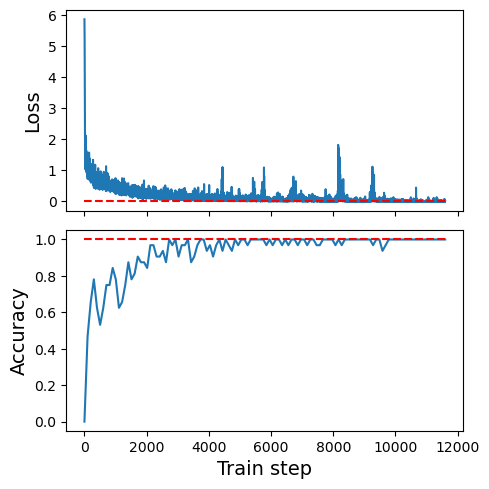

In [35]:
fig, axs = plt.subplots(2, sharex=True, figsize=(5, 5))
axs[0].plot(train_metrics['loss_history'])
axs[0].hlines(y=0, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[0].set_ylabel('Loss', fontsize=14)
axs[1].plot(np.linspace(0, len(train_metrics['loss_history']), len(train_metrics['test_acc_history'])), train_metrics['test_acc_history'])
axs[1].hlines(y=1, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[1].set_xlabel('Train step', fontsize=14)
axs[1].set_ylabel('Accuracy', fontsize=14)
axs[1].set_xlabel('Train step', fontsize=14)
fig.tight_layout()
fig.savefig(fig_outdir + 'train_history.png')

# Evaluate

## Predict only one step forward from each state in original schedule

In [40]:
eval_actions = []
success_sequence = []
azel_sequence = [(az, el) for az, el in zip (dataset.states[:, 0], dataset.states[:, 1])]

with torch.no_grad():
    for i, state in enumerate(dataset.states):
        q_vals = agent.algorithm.policy_net(state.to(device)).unsqueeze(0)
        action = torch.argmax(q_vals, dim=1).item()
        eval_actions.append(action)
        
        candidates_in_bin = np.array(dataset.id2azel[action])
        success_sequence.append(azel_sequence[i] in candidates_in_bin)
        dataset.actions

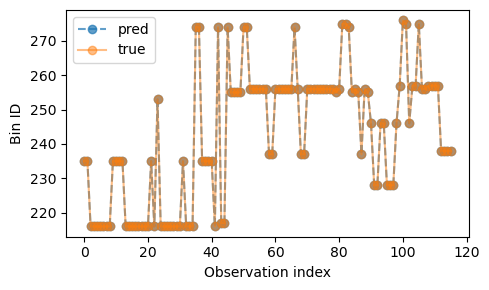

In [42]:
target_sequence = dataset.actions.detach().numpy()
eval_sequence = eval_actions

fig, axs = plt.subplots(1, figsize=(5,3))
axs.plot(eval_sequence, marker='o', linestyle='dashed', label='pred', alpha=.7)
axs.plot(target_sequence, marker='o', label='true', alpha=.5)
axs.legend()
axs.set_xlabel('Observation index')
axs.set_ylabel('Bin ID')

# axs[1].plot(eval_sequence - target_sequence, marker='o')
# axs[1].legend()
# axs[1].set_xlabel('obs index')
# axs[1].set_ylabel('pred - true')

fig.tight_layout()
fig.savefig(fig_outdir + 'learned_sequence.png')

## Predict the entire trajectory step-by-step

In [44]:
dataset.states

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-1.3566, -0.0671, -0.4942,  ...,  0.6210, -1.2305,  0.0000],
        [-1.3978, -0.1958, -0.4257,  ...,  0.8146, -1.1822, -1.6221],
        ...,
        [-0.4762, -0.3888,  0.7535,  ...,  0.6210,  2.2605,  1.7561],
        [ 0.1860, -0.3887,  0.6804,  ...,  0.0401,  1.9651,  1.7832],
        [ 0.1865, -0.3887,  0.6870,  ...,  0.0401,  1.9893,  1.8086]])

In [47]:
set(dataset._df['exptime'])

{90}

In [45]:
# from environments import OfflineEnv

# env_name = 'OfflineEnv'

# gym.register(
#     id=f"gymnasium_env/{env_name}",
#     entry_point=OfflineEnv,
#     max_episode_steps=300,  # Prevent infinite episodes. Here just set to 300 even though episode will terminate when stepping to last element of sequence
# )

# # for eval step only
# env_config = {
#     'id': f"gymnasium_env/{env_name}",
#     'dataset': dataset
# }


# env = gym.make(**env_config)
# from gymnasium.utils.env_checker import check_env

# # This will catch many common issues
# try:
#     check_env(env.unwrapped)
#     print("Environment passes all checks!")
# except Exception as e:
#     print(f"Environment has issues: {e}")

In [46]:
# agent.evaluate(env=env, num_episodes=1)
# with open(outdir + 'eval_metrics.pkl', 'rb') as handle:
#     eval_metrics = pickle.load(handle)

In [47]:
# target_sequence = dataset._schedule_field_ids[0]
# eval_sequence = eval_metrics['observations']['ep-0'][:, 0]

# fig, axs = plt.subplots(2)
# axs[0].plot(eval_sequence, marker='o', label='pred')
# axs[0].plot(target_sequence, marker='o', linestyle='dashed', label='true')
# axs[0].legend()
# axs[0].set_xlabel('obs index')
# axs[0].set_ylabel('field id')

# axs[1].plot(eval_sequence - target_sequence, marker='o')
# axs[1].legend()
# axs[1].set_xlabel('obs index')
# axs[1].set_ylabel('pred - true')


# fig.savefig(fig_outdir + 'learned_sequence.png')

# Exp2: Multiple Nights

## Configure model, data selection, and training setup

In [48]:
SEED = 10
seed_everything(SEED)
torch.set_default_dtype(torch.float32)
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

In [51]:
num_bins_1d = 19
dataset = OfflineDECamDataset(
    df, 
    num_bins_1d=19, 
    normalize_state=True,
    specific_years=[2013],
    specific_months=[8, 9],
    specific_days=[31, 1, 2],
    # specific_filters=['r', 'g']
)

In [53]:
batch_size = 32
num_workers = 4
pin_memory = True if device == 'cuda' else False
trainloader = dataset.get_dataloader(batch_size, num_workers = num_workers, pin_memory = pin_memory)


In [54]:
"""Algorithm and Train setup"""

alg_config = {
    'obs_dim': dataset.obs_dim,
    'num_actions': dataset.num_actions,
    'hidden_dim': 64,
    'device': device,
    'lr': 2.5e-3,
    'loss_fxn': None, #torch.nn.cross_entropy,
    # 'use_double': True,
}
alg = BehaviorCloning(**alg_config)

fit_config = {
    'num_epochs' : 80,
    'batch_size': batch_size,
    # 'learning_start': 
    }

env_name = 'TelescopeEnv-v0'

def create_exp_name(alg, env_name, dataset, fit_config, alg_config):
    exp_name = f"{alg.name}"
    exp_name += f"-{env_name}"
    exp_name += f"-n_nights={dataset.n_nights}"
    # config_prefix += f"-use_double={alg_config['use_double']}"
    exp_name += f"-num_epochs={fit_config['num_epochs']}"
    exp_name += f"-batch_size={fit_config['batch_size']}"
    exp_name += f"-lr={alg_config['lr']}"
    return exp_name

exp_name = create_exp_name(alg, env_name, dataset, fit_config, alg_config)

outdir = f'../results/{exp_name}/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
fig_outdir = outdir + 'figures/'
if not os.path.exists(fig_outdir):
    os.makedirs(fig_outdir)

agent_config = {
    'algorithm': alg,
    'normalize_obs': dataset.normalize_state,
    'outdir': outdir
    }

agent = Agent(**agent_config)



## Visualize dataset in (az, el) and binning sizes

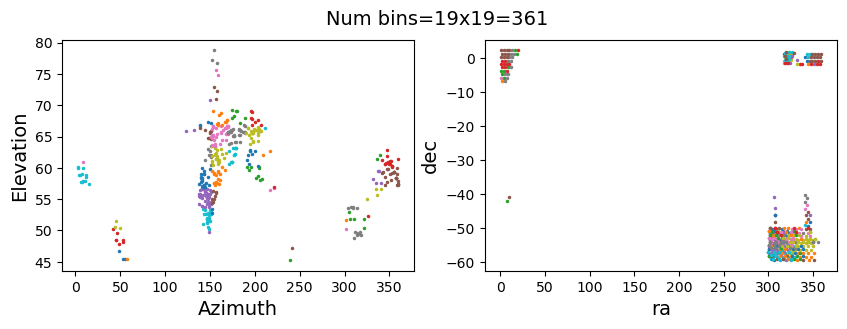

In [55]:
s = 1000/len(dataset)
fig, axs = plt.subplots(1,2, figsize=(10,3))
for bin_id in dataset.id2azel.keys():
    field_ids = np.array(dataset.id2azel[bin_id])
    axs[0].scatter(field_ids[:, 0], field_ids[:, 1], label='bin' + str(bin_id), s=s)
axs[0].set_xlabel('Azimuth', fontsize=14)
axs[0].set_ylabel('Elevation', fontsize=14)

for bin_id in dataset.id2radec.keys():
    field_ids = np.array(dataset.id2radec[bin_id])
    axs[1].scatter(field_ids[:, 0], field_ids[:, 1], label='bin' + str(bin_id), s=s)
axs[1].set_xlabel('ra', fontsize=14)
axs[1].set_ylabel('dec', fontsize=14)

fig.suptitle(f'Num bins={num_bins_1d}x{num_bins_1d}={dataset.num_actions}', fontsize=14)
fig.savefig(fig_outdir + 'plot_observations_in_sky_colored_bins.png')

## Train

In [56]:
start_time = time.time()
"""Train"""
agent.fit(
    dataloader=trainloader,
    **fit_config
    )
end_time = time.time()
train_time = end_time - start_time
print(f'Total train time = {train_time}s')

  0%|                                                 | 0/35520 [00:00<?, ?it/s]/home/hurra/Projects/survey-ops/survey_ops/src/algorithms.py:164: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expert_actions = torch.tensor(expert_actions, device=self.device, dtype=torch.long) # needs to be long for .gather()
/home/hurra/Projects/survey-ops/survey_ops/src/agents.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eval_obs = torch.tensor(eval_obs, device=self.device)
/home/hurra/Projects/survey-ops/survey_ops/src/agents.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather 

Train step 0: Accuracy = 0.031, Loss = 5.8675
Train step 100: Accuracy = 0.469, Loss = 1.6726


  1%|▎                                     | 350/35520 [00:00<00:37, 934.09it/s]

Train step 200: Accuracy = 0.375, Loss = 1.6279
Train step 300: Accuracy = 0.500, Loss = 1.6841
Train step 400: Accuracy = 0.656, Loss = 1.1312


  2%|▋                                    | 658/35520 [00:00<00:34, 1001.94it/s]

Train step 500: Accuracy = 0.594, Loss = 1.2036
Train step 600: Accuracy = 0.531, Loss = 1.2513
Train step 700: Accuracy = 0.594, Loss = 1.2044


  3%|█                                    | 963/35520 [00:01<00:34, 1005.27it/s]

Train step 800: Accuracy = 0.500, Loss = 1.0603
Train step 900: Accuracy = 0.531, Loss = 1.0176
Train step 1000: Accuracy = 0.688, Loss = 1.1534


  4%|█▎                                  | 1273/35520 [00:01<00:33, 1012.25it/s]

Train step 1100: Accuracy = 0.781, Loss = 1.0679
Train step 1200: Accuracy = 0.500, Loss = 0.8355
Train step 1300: Accuracy = 0.438, Loss = 0.8345


  4%|█▌                                  | 1580/35520 [00:01<00:33, 1012.66it/s]

Train step 1400: Accuracy = 0.531, Loss = 1.0384
Train step 1500: Accuracy = 0.625, Loss = 0.9640
Train step 1600: Accuracy = 0.656, Loss = 0.8778


  5%|█▉                                  | 1892/35520 [00:01<00:32, 1027.22it/s]

Train step 1700: Accuracy = 0.562, Loss = 1.1897
Train step 1800: Accuracy = 0.719, Loss = 0.9892
Train step 1900: Accuracy = 0.750, Loss = 0.8429


  6%|██▏                                 | 2106/35520 [00:02<00:32, 1042.70it/s]

Train step 2000: Accuracy = 0.625, Loss = 1.0443
Train step 2100: Accuracy = 0.438, Loss = 0.9742
Train step 2200: Accuracy = 0.781, Loss = 0.7783


  7%|██▍                                 | 2418/35520 [00:02<00:32, 1020.52it/s]

Train step 2300: Accuracy = 0.500, Loss = 0.5533
Train step 2400: Accuracy = 0.625, Loss = 0.8156
Train step 2500: Accuracy = 0.719, Loss = 0.7255


  8%|██▊                                 | 2725/35520 [00:02<00:32, 1011.21it/s]

Train step 2600: Accuracy = 0.656, Loss = 0.8766
Train step 2700: Accuracy = 0.531, Loss = 0.9217
Train step 2800: Accuracy = 0.781, Loss = 0.6700


  9%|███                                 | 3033/35520 [00:03<00:31, 1018.65it/s]

Train step 2900: Accuracy = 0.719, Loss = 0.7075
Train step 3000: Accuracy = 0.719, Loss = 0.5944
Train step 3100: Accuracy = 0.688, Loss = 0.6879


  9%|███▍                                | 3343/35520 [00:03<00:31, 1023.14it/s]

Train step 3200: Accuracy = 0.688, Loss = 0.6699
Train step 3300: Accuracy = 0.750, Loss = 0.6129
Train step 3400: Accuracy = 0.688, Loss = 0.8362


 10%|███▋                                | 3651/35520 [00:03<00:31, 1008.96it/s]

Train step 3500: Accuracy = 0.500, Loss = 0.5127
Train step 3600: Accuracy = 0.625, Loss = 0.7221
Train step 3700: Accuracy = 0.625, Loss = 0.5614


 11%|████                                | 3959/35520 [00:03<00:31, 1015.63it/s]

Train step 3800: Accuracy = 0.719, Loss = 0.5310
Train step 3900: Accuracy = 0.750, Loss = 0.9269
Train step 4000: Accuracy = 0.750, Loss = 0.6190


 12%|████▎                               | 4271/35520 [00:04<00:30, 1026.90it/s]

Train step 4100: Accuracy = 0.688, Loss = 0.7971
Train step 4200: Accuracy = 0.656, Loss = 0.7501
Train step 4300: Accuracy = 0.781, Loss = 0.6249


 13%|████▋                               | 4591/35520 [00:04<00:29, 1051.10it/s]

Train step 4400: Accuracy = 0.625, Loss = 0.7581
Train step 4500: Accuracy = 0.844, Loss = 0.5922
Train step 4600: Accuracy = 0.719, Loss = 0.6672


 14%|████▉                               | 4908/35520 [00:04<00:29, 1040.22it/s]

Train step 4700: Accuracy = 0.719, Loss = 0.8696
Train step 4800: Accuracy = 0.750, Loss = 0.6211
Train step 4900: Accuracy = 0.656, Loss = 0.7134


 14%|█████▏                              | 5118/35520 [00:05<00:29, 1040.54it/s]

Train step 5000: Accuracy = 0.750, Loss = 0.6985
Train step 5100: Accuracy = 0.781, Loss = 0.4452
Train step 5200: Accuracy = 0.594, Loss = 0.7040


 15%|█████▌                              | 5439/35520 [00:05<00:28, 1050.39it/s]

Train step 5300: Accuracy = 0.688, Loss = 0.4349
Train step 5400: Accuracy = 0.688, Loss = 0.4996
Train step 5500: Accuracy = 0.781, Loss = 0.4182


 16%|█████▊                              | 5757/35520 [00:05<00:28, 1049.47it/s]

Train step 5600: Accuracy = 0.688, Loss = 0.6100
Train step 5700: Accuracy = 0.781, Loss = 0.5675
Train step 5800: Accuracy = 0.688, Loss = 0.7028


 17%|██████▏                             | 6070/35520 [00:05<00:28, 1036.40it/s]

Train step 5900: Accuracy = 0.719, Loss = 0.5059
Train step 6000: Accuracy = 0.688, Loss = 0.4578
Train step 6100: Accuracy = 0.844, Loss = 0.5127


 18%|██████▍                             | 6385/35520 [00:06<00:27, 1045.74it/s]

Train step 6200: Accuracy = 0.781, Loss = 0.4283
Train step 6300: Accuracy = 0.844, Loss = 0.6082
Train step 6400: Accuracy = 0.719, Loss = 0.4335


 19%|██████▊                             | 6700/35520 [00:06<00:27, 1038.23it/s]

Train step 6500: Accuracy = 0.781, Loss = 0.4832
Train step 6600: Accuracy = 0.750, Loss = 0.5209
Train step 6700: Accuracy = 0.812, Loss = 0.5443


 19%|███████                             | 6909/35520 [00:06<00:27, 1024.31it/s]

Train step 6800: Accuracy = 0.812, Loss = 0.5046
Train step 6900: Accuracy = 0.844, Loss = 0.5088
Train step 7000: Accuracy = 0.562, Loss = 0.6062


 20%|███████▎                            | 7217/35520 [00:07<00:27, 1014.02it/s]

Train step 7100: Accuracy = 0.688, Loss = 0.8184
Train step 7200: Accuracy = 0.875, Loss = 0.4959
Train step 7300: Accuracy = 0.719, Loss = 0.4025


 21%|███████▋                            | 7530/35520 [00:07<00:27, 1033.23it/s]

Train step 7400: Accuracy = 0.781, Loss = 0.6588
Train step 7500: Accuracy = 0.875, Loss = 0.4376
Train step 7600: Accuracy = 0.844, Loss = 0.6867


 22%|███████▉                            | 7848/35520 [00:07<00:26, 1044.99it/s]

Train step 7700: Accuracy = 0.938, Loss = 0.1602
Train step 7800: Accuracy = 0.781, Loss = 0.2850
Train step 7900: Accuracy = 0.781, Loss = 0.2625


 23%|████████▎                           | 8168/35520 [00:08<00:26, 1038.29it/s]

Train step 8000: Accuracy = 0.781, Loss = 0.4352
Train step 8100: Accuracy = 0.781, Loss = 0.3549
Train step 8200: Accuracy = 0.656, Loss = 0.5361


 24%|████████▌                           | 8485/35520 [00:08<00:25, 1040.01it/s]

Train step 8300: Accuracy = 0.781, Loss = 0.3011
Train step 8400: Accuracy = 0.906, Loss = 0.3564
Train step 8500: Accuracy = 0.875, Loss = 0.4089


 25%|████████▉                           | 8799/35520 [00:08<00:25, 1033.58it/s]

Train step 8600: Accuracy = 0.844, Loss = 0.3461
Train step 8700: Accuracy = 0.812, Loss = 0.6169
Train step 8800: Accuracy = 0.844, Loss = 0.3926


 25%|█████████▏                          | 9017/35520 [00:08<00:24, 1061.42it/s]

Train step 8900: Accuracy = 0.750, Loss = 0.3296
Train step 9000: Accuracy = 0.906, Loss = 0.4733
Train step 9100: Accuracy = 0.906, Loss = 0.2775


 26%|█████████▍                          | 9335/35520 [00:09<00:25, 1038.65it/s]

Train step 9200: Accuracy = 0.844, Loss = 0.3962
Train step 9300: Accuracy = 0.781, Loss = 0.5196
Train step 9400: Accuracy = 0.906, Loss = 0.3230


 27%|█████████▊                          | 9654/35520 [00:09<00:24, 1053.16it/s]

Train step 9500: Accuracy = 0.812, Loss = 0.3157
Train step 9600: Accuracy = 0.875, Loss = 0.3046
Train step 9700: Accuracy = 0.938, Loss = 0.3353


 28%|██████████                          | 9972/35520 [00:09<00:24, 1045.39it/s]

Train step 9800: Accuracy = 0.844, Loss = 0.3379
Train step 9900: Accuracy = 0.844, Loss = 0.2343
Train step 10000: Accuracy = 0.844, Loss = 0.5745


 29%|██████████▏                        | 10286/35520 [00:10<00:24, 1023.90it/s]

Train step 10100: Accuracy = 0.844, Loss = 0.2901
Train step 10200: Accuracy = 0.844, Loss = 0.5676
Train step 10300: Accuracy = 0.875, Loss = 0.4109


 30%|██████████▍                        | 10608/35520 [00:10<00:23, 1052.60it/s]

Train step 10400: Accuracy = 0.875, Loss = 0.4999
Train step 10500: Accuracy = 0.906, Loss = 0.2226
Train step 10600: Accuracy = 0.875, Loss = 0.2656


 30%|██████████▋                        | 10821/35520 [00:10<00:23, 1049.02it/s]

Train step 10700: Accuracy = 0.812, Loss = 0.5326
Train step 10800: Accuracy = 0.844, Loss = 0.2567
Train step 10900: Accuracy = 0.719, Loss = 0.2557


 31%|██████████▉                        | 11141/35520 [00:10<00:23, 1043.02it/s]

Train step 11000: Accuracy = 0.875, Loss = 0.3520
Train step 11100: Accuracy = 0.938, Loss = 0.3252
Train step 11200: Accuracy = 0.875, Loss = 0.2405


 32%|███████████▎                       | 11457/35520 [00:11<00:22, 1047.63it/s]

Train step 11300: Accuracy = 0.906, Loss = 0.2499
Train step 11400: Accuracy = 0.844, Loss = 0.3501
Train step 11500: Accuracy = 0.844, Loss = 0.2922


 33%|███████████▌                       | 11776/35520 [00:11<00:22, 1053.59it/s]

Train step 11600: Accuracy = 0.906, Loss = 0.3157
Train step 11700: Accuracy = 0.906, Loss = 0.2610
Train step 11800: Accuracy = 0.844, Loss = 0.5144


 34%|███████████▉                       | 12097/35520 [00:11<00:22, 1061.25it/s]

Train step 11900: Accuracy = 0.906, Loss = 0.1749
Train step 12000: Accuracy = 0.906, Loss = 0.3298
Train step 12100: Accuracy = 0.938, Loss = 0.2236


 35%|████████████▏                      | 12311/35520 [00:11<00:22, 1050.48it/s]

Train step 12200: Accuracy = 0.875, Loss = 0.3808
Train step 12300: Accuracy = 0.844, Loss = 0.2028
Train step 12400: Accuracy = 0.906, Loss = 0.1914


 36%|████████████▍                      | 12629/35520 [00:12<00:21, 1049.01it/s]

Train step 12500: Accuracy = 0.906, Loss = 0.3893
Train step 12600: Accuracy = 0.969, Loss = 0.1791
Train step 12700: Accuracy = 0.906, Loss = 0.2893


 36%|████████████▊                      | 12946/35520 [00:12<00:21, 1049.54it/s]

Train step 12800: Accuracy = 0.875, Loss = 0.2598
Train step 12900: Accuracy = 0.938, Loss = 0.3552
Train step 13000: Accuracy = 0.875, Loss = 0.2038


 37%|█████████████                      | 13266/35520 [00:12<00:21, 1055.04it/s]

Train step 13100: Accuracy = 1.000, Loss = 0.2539
Train step 13200: Accuracy = 0.938, Loss = 0.2557
Train step 13300: Accuracy = 1.000, Loss = 0.1551


 38%|█████████████▍                     | 13585/35520 [00:13<00:21, 1043.81it/s]

Train step 13400: Accuracy = 0.938, Loss = 0.4720
Train step 13500: Accuracy = 0.875, Loss = 0.2852
Train step 13600: Accuracy = 1.000, Loss = 0.2424


 39%|█████████████▋                     | 13901/35520 [00:13<00:20, 1037.15it/s]

Train step 13700: Accuracy = 0.875, Loss = 0.3315
Train step 13800: Accuracy = 0.969, Loss = 0.1831
Train step 13900: Accuracy = 0.938, Loss = 0.2226


 40%|█████████████▉                     | 14110/35520 [00:13<00:20, 1035.40it/s]

Train step 14000: Accuracy = 0.906, Loss = 0.2428
Train step 14100: Accuracy = 1.000, Loss = 0.1499
Train step 14200: Accuracy = 0.875, Loss = 0.1976


 41%|██████████████▏                    | 14424/35520 [00:13<00:20, 1030.70it/s]

Train step 14300: Accuracy = 0.938, Loss = 0.1823
Train step 14400: Accuracy = 0.938, Loss = 0.2331
Train step 14500: Accuracy = 0.969, Loss = 0.1731


 42%|██████████████▌                    | 14769/35520 [00:14<00:18, 1100.92it/s]

Train step 14600: Accuracy = 0.875, Loss = 0.3113
Train step 14700: Accuracy = 0.906, Loss = 0.2177
Train step 14800: Accuracy = 0.938, Loss = 0.5087


 43%|██████████████▉                    | 15105/35520 [00:14<00:18, 1105.25it/s]

Train step 14900: Accuracy = 0.906, Loss = 0.3484
Train step 15000: Accuracy = 0.906, Loss = 0.2660
Train step 15100: Accuracy = 0.938, Loss = 0.2551


 43%|███████████████                    | 15326/35520 [00:14<00:18, 1076.62it/s]

Train step 15200: Accuracy = 0.938, Loss = 0.4104
Train step 15300: Accuracy = 0.938, Loss = 0.2907
Train step 15400: Accuracy = 0.875, Loss = 0.2007


 44%|███████████████▍                   | 15647/35520 [00:15<00:18, 1058.30it/s]

Train step 15500: Accuracy = 0.969, Loss = 0.1667
Train step 15600: Accuracy = 0.969, Loss = 0.2046
Train step 15700: Accuracy = 0.969, Loss = 0.2023


 45%|███████████████▋                   | 15965/35520 [00:15<00:18, 1041.15it/s]

Train step 15800: Accuracy = 0.938, Loss = 0.1424
Train step 15900: Accuracy = 0.969, Loss = 0.2707
Train step 16000: Accuracy = 0.938, Loss = 0.1747


 46%|████████████████                   | 16279/35520 [00:15<00:18, 1036.05it/s]

Train step 16100: Accuracy = 0.781, Loss = 0.2338
Train step 16200: Accuracy = 0.969, Loss = 0.3040
Train step 16300: Accuracy = 0.906, Loss = 0.2161


 47%|████████████████▎                  | 16590/35520 [00:16<00:18, 1017.65it/s]

Train step 16400: Accuracy = 0.875, Loss = 0.1650
Train step 16500: Accuracy = 0.938, Loss = 0.0859
Train step 16600: Accuracy = 0.938, Loss = 0.0743


 48%|████████████████▋                  | 16898/35520 [00:16<00:18, 1019.28it/s]

Train step 16700: Accuracy = 1.000, Loss = 0.2228
Train step 16800: Accuracy = 0.969, Loss = 0.2084
Train step 16900: Accuracy = 0.906, Loss = 0.2393


 48%|████████████████▊                  | 17115/35520 [00:16<00:17, 1056.05it/s]

Train step 17000: Accuracy = 1.000, Loss = 0.1657
Train step 17100: Accuracy = 0.906, Loss = 0.2736
Train step 17200: Accuracy = 0.969, Loss = 0.1286


 49%|█████████████████▏                 | 17465/35520 [00:16<00:16, 1091.35it/s]

Train step 17300: Accuracy = 1.000, Loss = 0.1368
Train step 17400: Accuracy = 0.906, Loss = 0.5588
Train step 17500: Accuracy = 0.938, Loss = 0.2239


 50%|█████████████████▌                 | 17791/35520 [00:17<00:16, 1067.93it/s]

Train step 17600: Accuracy = 0.906, Loss = 0.1520
Train step 17700: Accuracy = 0.938, Loss = 0.1995
Train step 17800: Accuracy = 0.875, Loss = 0.1797


 51%|█████████████████▋                 | 18005/35520 [00:17<00:16, 1052.46it/s]

Train step 17900: Accuracy = 0.969, Loss = 0.3374
Train step 18000: Accuracy = 1.000, Loss = 0.2201
Train step 18100: Accuracy = 0.969, Loss = 0.1622


 52%|██████████████████                 | 18321/35520 [00:17<00:16, 1043.30it/s]

Train step 18200: Accuracy = 0.875, Loss = 0.2821
Train step 18300: Accuracy = 0.969, Loss = 0.0919
Train step 18400: Accuracy = 0.969, Loss = 0.1313


 52%|██████████████████▎                | 18638/35520 [00:17<00:16, 1050.69it/s]

Train step 18500: Accuracy = 0.844, Loss = 0.1313
Train step 18600: Accuracy = 0.969, Loss = 0.1560
Train step 18700: Accuracy = 0.969, Loss = 0.0935


 53%|██████████████████▋                | 18957/35520 [00:18<00:15, 1047.89it/s]

Train step 18800: Accuracy = 0.938, Loss = 0.0717
Train step 18900: Accuracy = 0.906, Loss = 0.3939
Train step 19000: Accuracy = 0.906, Loss = 0.1249


 54%|██████████████████▉                | 19273/35520 [00:18<00:15, 1045.45it/s]

Train step 19100: Accuracy = 0.938, Loss = 0.0853
Train step 19200: Accuracy = 0.969, Loss = 0.2845
Train step 19300: Accuracy = 0.938, Loss = 0.5674


 55%|███████████████████▎               | 19590/35520 [00:18<00:15, 1050.92it/s]

Train step 19400: Accuracy = 1.000, Loss = 0.2316
Train step 19500: Accuracy = 1.000, Loss = 0.1033
Train step 19600: Accuracy = 0.906, Loss = 0.1057


 56%|███████████████████▌               | 19907/35520 [00:19<00:15, 1038.35it/s]

Train step 19700: Accuracy = 1.000, Loss = 0.0607
Train step 19800: Accuracy = 1.000, Loss = 0.2297
Train step 19900: Accuracy = 1.000, Loss = 0.1071


 57%|███████████████████▊               | 20115/35520 [00:19<00:14, 1031.08it/s]

Train step 20000: Accuracy = 0.906, Loss = 0.1019
Train step 20100: Accuracy = 0.906, Loss = 0.0587
Train step 20200: Accuracy = 0.875, Loss = 0.1748


 58%|████████████████████▏              | 20433/35520 [00:19<00:14, 1046.19it/s]

Train step 20300: Accuracy = 0.969, Loss = 0.3505
Train step 20400: Accuracy = 0.938, Loss = 0.1530
Train step 20500: Accuracy = 0.969, Loss = 0.0856


 58%|████████████████████▍              | 20751/35520 [00:19<00:14, 1052.43it/s]

Train step 20600: Accuracy = 1.000, Loss = 0.1075
Train step 20700: Accuracy = 1.000, Loss = 0.1590
Train step 20800: Accuracy = 0.969, Loss = 0.0706


 59%|████████████████████▊              | 21069/35520 [00:20<00:13, 1045.45it/s]

Train step 20900: Accuracy = 1.000, Loss = 0.0750
Train step 21000: Accuracy = 0.938, Loss = 0.1759
Train step 21100: Accuracy = 0.938, Loss = 0.1521


 60%|█████████████████████              | 21383/35520 [00:20<00:13, 1037.13it/s]

Train step 21200: Accuracy = 0.906, Loss = 0.1620
Train step 21300: Accuracy = 1.000, Loss = 0.1137
Train step 21400: Accuracy = 1.000, Loss = 0.2804


 61%|█████████████████████▍             | 21699/35520 [00:20<00:13, 1023.25it/s]

Train step 21500: Accuracy = 0.969, Loss = 0.0849
Train step 21600: Accuracy = 0.906, Loss = 0.1206
Train step 21700: Accuracy = 0.938, Loss = 0.0917


 62%|█████████████████████▌             | 21909/35520 [00:21<00:13, 1033.48it/s]

Train step 21800: Accuracy = 0.938, Loss = 0.2544
Train step 21900: Accuracy = 0.906, Loss = 0.2420
Train step 22000: Accuracy = 0.812, Loss = 0.0723


 63%|█████████████████████▉             | 22229/35520 [00:21<00:12, 1048.80it/s]

Train step 22100: Accuracy = 0.969, Loss = 0.0733
Train step 22200: Accuracy = 0.969, Loss = 0.2518
Train step 22300: Accuracy = 0.906, Loss = 0.2173


 63%|██████████████████████▏            | 22548/35520 [00:21<00:12, 1049.81it/s]

Train step 22400: Accuracy = 0.938, Loss = 0.0386
Train step 22500: Accuracy = 0.938, Loss = 0.0667
Train step 22600: Accuracy = 1.000, Loss = 0.1834


 64%|██████████████████████▌            | 22859/35520 [00:22<00:12, 1014.87it/s]

Train step 22700: Accuracy = 0.969, Loss = 0.0920
Train step 22800: Accuracy = 0.969, Loss = 0.1686
Train step 22900: Accuracy = 0.969, Loss = 0.1632


 65%|██████████████████████▊            | 23168/35520 [00:22<00:12, 1004.24it/s]

Train step 23000: Accuracy = 1.000, Loss = 0.1212
Train step 23100: Accuracy = 0.906, Loss = 0.0983


 66%|███████████████████████▋            | 23369/35520 [00:22<00:12, 993.21it/s]

Train step 23200: Accuracy = 0.906, Loss = 0.0245
Train step 23300: Accuracy = 0.969, Loss = 0.0721
Train step 23400: Accuracy = 1.000, Loss = 0.1541


 67%|███████████████████████▎           | 23690/35520 [00:22<00:11, 1042.13it/s]

Train step 23500: Accuracy = 1.000, Loss = 0.0974
Train step 23600: Accuracy = 0.938, Loss = 0.0370
Train step 23700: Accuracy = 1.000, Loss = 0.0877


 68%|███████████████████████▋           | 24001/35520 [00:23<00:11, 1011.71it/s]

Train step 23800: Accuracy = 0.969, Loss = 0.0565
Train step 23900: Accuracy = 0.938, Loss = 0.0442
Train step 24000: Accuracy = 0.906, Loss = 0.0966


 68%|███████████████████████▊           | 24205/35520 [00:23<00:11, 1014.65it/s]

Train step 24100: Accuracy = 0.906, Loss = 0.2173
Train step 24200: Accuracy = 0.938, Loss = 0.1211
Train step 24300: Accuracy = 0.812, Loss = 0.1584


 69%|████████████████████████▏          | 24527/35520 [00:23<00:10, 1057.05it/s]

Train step 24400: Accuracy = 0.969, Loss = 0.0870
Train step 24500: Accuracy = 1.000, Loss = 0.1315
Train step 24600: Accuracy = 1.000, Loss = 0.1784


 70%|████████████████████████▌          | 24872/35520 [00:23<00:09, 1118.04it/s]

Train step 24700: Accuracy = 1.000, Loss = 0.0740
Train step 24800: Accuracy = 0.906, Loss = 0.1018
Train step 24900: Accuracy = 0.969, Loss = 0.1259


 71%|████████████████████████▊          | 25224/35520 [00:24<00:08, 1156.72it/s]

Train step 25000: Accuracy = 0.938, Loss = 0.0768
Train step 25100: Accuracy = 0.969, Loss = 0.0978
Train step 25200: Accuracy = 1.000, Loss = 0.0454


 72%|█████████████████████████          | 25456/35520 [00:24<00:08, 1136.80it/s]

Train step 25300: Accuracy = 0.906, Loss = 0.0632
Train step 25400: Accuracy = 0.812, Loss = 0.5391
Train step 25500: Accuracy = 0.969, Loss = 0.4907


 73%|█████████████████████████▍         | 25797/35520 [00:24<00:08, 1105.94it/s]

Train step 25600: Accuracy = 0.938, Loss = 0.1621
Train step 25700: Accuracy = 0.938, Loss = 0.0425
Train step 25800: Accuracy = 1.000, Loss = 0.0420


 73%|█████████████████████████▋         | 26017/35520 [00:25<00:08, 1069.22it/s]

Train step 25900: Accuracy = 1.000, Loss = 0.0334
Train step 26000: Accuracy = 0.969, Loss = 0.0379
Train step 26100: Accuracy = 1.000, Loss = 0.0198


 74%|█████████████████████████▉         | 26340/35520 [00:25<00:08, 1062.16it/s]

Train step 26200: Accuracy = 0.938, Loss = 0.1288
Train step 26300: Accuracy = 1.000, Loss = 0.1919
Train step 26400: Accuracy = 1.000, Loss = 0.0475


 75%|██████████████████████████▎        | 26663/35520 [00:25<00:08, 1058.31it/s]

Train step 26500: Accuracy = 0.938, Loss = 0.4043
Train step 26600: Accuracy = 0.969, Loss = 0.1559
Train step 26700: Accuracy = 0.969, Loss = 0.0605


 76%|██████████████████████████▌        | 26981/35520 [00:25<00:08, 1041.34it/s]

Train step 26800: Accuracy = 0.906, Loss = 0.0949
Train step 26900: Accuracy = 0.906, Loss = 0.1073
Train step 27000: Accuracy = 1.000, Loss = 0.0361


 77%|██████████████████████████▉        | 27300/35520 [00:26<00:07, 1054.03it/s]

Train step 27100: Accuracy = 0.969, Loss = 0.0729
Train step 27200: Accuracy = 0.938, Loss = 0.2094
Train step 27300: Accuracy = 0.906, Loss = 0.0646


 77%|███████████████████████████        | 27512/35520 [00:26<00:07, 1049.40it/s]

Train step 27400: Accuracy = 0.969, Loss = 0.0822
Train step 27500: Accuracy = 0.906, Loss = 0.2779
Train step 27600: Accuracy = 1.000, Loss = 0.1415


 78%|███████████████████████████▍       | 27828/35520 [00:26<00:07, 1048.59it/s]

Train step 27700: Accuracy = 0.938, Loss = 0.0436
Train step 27800: Accuracy = 0.969, Loss = 0.1898
Train step 27900: Accuracy = 0.969, Loss = 0.2408


 79%|███████████████████████████▋       | 28144/35520 [00:27<00:07, 1044.85it/s]

Train step 28000: Accuracy = 0.969, Loss = 0.0908
Train step 28100: Accuracy = 0.938, Loss = 0.1241
Train step 28200: Accuracy = 0.969, Loss = 0.0738


 80%|████████████████████████████       | 28464/35520 [00:27<00:06, 1055.44it/s]

Train step 28300: Accuracy = 0.938, Loss = 0.3285
Train step 28400: Accuracy = 0.969, Loss = 0.0541
Train step 28500: Accuracy = 0.969, Loss = 0.2339


 81%|████████████████████████████▎      | 28782/35520 [00:27<00:06, 1047.88it/s]

Train step 28600: Accuracy = 0.938, Loss = 0.0587
Train step 28700: Accuracy = 0.969, Loss = 0.0451
Train step 28800: Accuracy = 0.969, Loss = 0.2052


 82%|████████████████████████████▋      | 29099/35520 [00:27<00:06, 1039.56it/s]

Train step 28900: Accuracy = 0.938, Loss = 0.1873
Train step 29000: Accuracy = 0.969, Loss = 0.0474
Train step 29100: Accuracy = 1.000, Loss = 0.0353


 83%|████████████████████████████▉      | 29311/35520 [00:28<00:05, 1050.67it/s]

Train step 29200: Accuracy = 0.969, Loss = 0.3654
Train step 29300: Accuracy = 0.969, Loss = 0.0416
Train step 29400: Accuracy = 0.906, Loss = 0.1720


 83%|█████████████████████████████▏     | 29630/35520 [00:28<00:05, 1049.24it/s]

Train step 29500: Accuracy = 0.938, Loss = 0.1445
Train step 29600: Accuracy = 0.969, Loss = 0.0545
Train step 29700: Accuracy = 0.938, Loss = 0.0370


 84%|█████████████████████████████▌     | 29945/35520 [00:28<00:05, 1040.07it/s]

Train step 29800: Accuracy = 0.969, Loss = 0.0844
Train step 29900: Accuracy = 0.969, Loss = 0.0728
Train step 30000: Accuracy = 1.000, Loss = 0.0688


 85%|█████████████████████████████▊     | 30259/35520 [00:29<00:05, 1035.05it/s]

Train step 30100: Accuracy = 0.969, Loss = 0.0674
Train step 30200: Accuracy = 0.938, Loss = 0.0837
Train step 30300: Accuracy = 0.969, Loss = 0.0352


 86%|██████████████████████████████▏    | 30573/35520 [00:29<00:04, 1040.95it/s]

Train step 30400: Accuracy = 0.938, Loss = 0.0479
Train step 30500: Accuracy = 0.906, Loss = 0.0369
Train step 30600: Accuracy = 0.969, Loss = 0.2388


 87%|██████████████████████████████▍    | 30885/35520 [00:29<00:04, 1017.00it/s]

Train step 30700: Accuracy = 0.969, Loss = 0.0268
Train step 30800: Accuracy = 0.969, Loss = 0.1168
Train step 30900: Accuracy = 0.938, Loss = 0.0985


 88%|██████████████████████████████▋    | 31199/35520 [00:29<00:04, 1024.58it/s]

Train step 31000: Accuracy = 0.969, Loss = 0.2728
Train step 31100: Accuracy = 1.000, Loss = 0.0317
Train step 31200: Accuracy = 0.875, Loss = 0.4249


 88%|██████████████████████████████▉    | 31412/35520 [00:30<00:03, 1042.87it/s]

Train step 31300: Accuracy = 0.938, Loss = 0.0388
Train step 31400: Accuracy = 0.938, Loss = 0.0602
Train step 31500: Accuracy = 0.969, Loss = 0.3000


 89%|███████████████████████████████▎   | 31733/35520 [00:30<00:03, 1058.13it/s]

Train step 31600: Accuracy = 1.000, Loss = 0.1672
Train step 31700: Accuracy = 0.938, Loss = 0.1379
Train step 31800: Accuracy = 0.938, Loss = 0.1345


 90%|███████████████████████████████▌   | 32055/35520 [00:30<00:03, 1057.97it/s]

Train step 31900: Accuracy = 0.844, Loss = 0.0595
Train step 32000: Accuracy = 0.906, Loss = 0.0762
Train step 32100: Accuracy = 0.938, Loss = 0.0373


 91%|███████████████████████████████▉   | 32373/35520 [00:31<00:03, 1044.29it/s]

Train step 32200: Accuracy = 0.844, Loss = 0.0223
Train step 32300: Accuracy = 0.969, Loss = 0.0322
Train step 32400: Accuracy = 1.000, Loss = 0.1285


 92%|████████████████████████████████▏  | 32695/35520 [00:31<00:02, 1060.88it/s]

Train step 32500: Accuracy = 0.969, Loss = 0.0563
Train step 32600: Accuracy = 0.969, Loss = 0.1182
Train step 32700: Accuracy = 1.000, Loss = 0.0292


 93%|████████████████████████████████▍  | 32912/35520 [00:31<00:02, 1064.14it/s]

Train step 32800: Accuracy = 0.969, Loss = 0.0565
Train step 32900: Accuracy = 0.969, Loss = 0.0170
Train step 33000: Accuracy = 0.938, Loss = 0.0758


 94%|████████████████████████████████▋  | 33235/35520 [00:31<00:02, 1067.01it/s]

Train step 33100: Accuracy = 0.969, Loss = 0.1351
Train step 33200: Accuracy = 0.938, Loss = 0.2931
Train step 33300: Accuracy = 0.906, Loss = 0.0183


 94%|█████████████████████████████████  | 33556/35520 [00:32<00:01, 1049.89it/s]

Train step 33400: Accuracy = 0.969, Loss = 0.0289
Train step 33500: Accuracy = 0.969, Loss = 0.0615
Train step 33600: Accuracy = 1.000, Loss = 0.0601


 95%|█████████████████████████████████▍ | 33874/35520 [00:32<00:01, 1042.41it/s]

Train step 33700: Accuracy = 0.906, Loss = 0.0714
Train step 33800: Accuracy = 1.000, Loss = 0.1111
Train step 33900: Accuracy = 0.875, Loss = 0.1270


 96%|█████████████████████████████████▋ | 34194/35520 [00:32<00:01, 1053.10it/s]

Train step 34000: Accuracy = 0.969, Loss = 0.1111
Train step 34100: Accuracy = 0.844, Loss = 0.0993
Train step 34200: Accuracy = 1.000, Loss = 0.1114


 97%|█████████████████████████████████▉ | 34407/35520 [00:33<00:01, 1051.34it/s]

Train step 34300: Accuracy = 0.938, Loss = 0.0104
Train step 34400: Accuracy = 0.969, Loss = 0.0788
Train step 34500: Accuracy = 1.000, Loss = 0.0440


 98%|██████████████████████████████████▏| 34735/35520 [00:33<00:00, 1063.43it/s]

Train step 34600: Accuracy = 1.000, Loss = 0.0478
Train step 34700: Accuracy = 0.938, Loss = 0.0488
Train step 34800: Accuracy = 0.969, Loss = 0.0342


 99%|██████████████████████████████████▌| 35065/35520 [00:33<00:00, 1087.89it/s]

Train step 34900: Accuracy = 0.875, Loss = 0.2197
Train step 35000: Accuracy = 0.969, Loss = 0.0936
Train step 35100: Accuracy = 1.000, Loss = 0.0782


100%|██████████████████████████████████▉| 35395/35520 [00:33<00:00, 1075.40it/s]

Train step 35200: Accuracy = 1.000, Loss = 0.2905
Train step 35300: Accuracy = 0.969, Loss = 0.0442
Train step 35400: Accuracy = 1.000, Loss = 0.1642


100%|███████████████████████████████████| 35520/35520 [00:34<00:00, 1043.03it/s]

Train step 35500: Accuracy = 0.969, Loss = 0.1909
Total train time = 34.1289439201355s


In [57]:
with open(outdir + 'train_metrics.pkl', 'rb') as handle:
    train_metrics = pickle.load(handle)

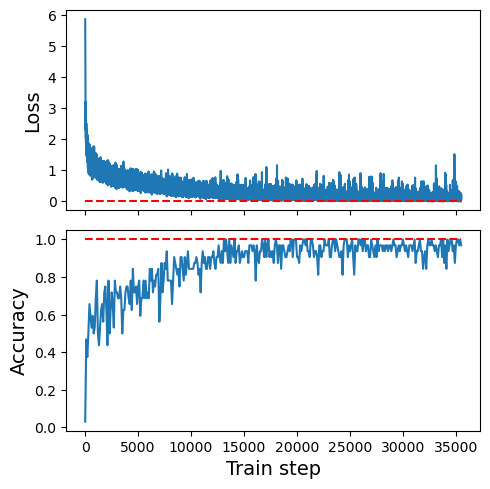

In [58]:
fig, axs = plt.subplots(2, sharex=True, figsize=(5, 5))
axs[0].plot(train_metrics['loss_history'])
axs[0].hlines(y=0, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[0].set_ylabel('Loss', fontsize=14)
axs[1].plot(np.linspace(0, len(train_metrics['loss_history']), len(train_metrics['test_acc_history'])), train_metrics['test_acc_history'])
axs[1].hlines(y=1, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[1].set_xlabel('Train step', fontsize=14)
axs[1].set_ylabel('Accuracy', fontsize=14)
axs[1].set_xlabel('Train step', fontsize=14)
fig.tight_layout()
fig.savefig(fig_outdir + 'train_history.png')

## Evaluate

In [59]:
dataset._df

,expnum,ra,dec,exptime,filter,propid,program,teff,fwhm,datetime,az,zd,ha,airmass,qc_fwhm,qc_cloud,qc_sky,qc_teff,timestamp,night
0,229250,301.199036,-50.938332,90,g,2012B-0001,survey,0.41,1.15,2013-08-31 23:55:07,139.550003,32.209999,-33.208458,1.18,1.15,0.42,1.26,0.41,1377993307,2013-08-31
1,229251,300.851105,-52.967278,90,g,2012B-0001,survey,0.60,1.18,2013-08-31 23:57:08,143.320007,32.759998,-32.380917,1.19,1.18,0.15,1.23,0.60,1377993428,2013-08-31
2,229252,300.460083,-54.996220,90,g,2012B-0001,survey,0.62,1.17,2013-08-31 23:59:08,146.949997,33.419998,-31.494499,1.20,1.17,-0.07,1.22,0.62,1377993548,2013-08-31
3,229253,300.016754,-57.024887,90,g,2012B-0001,survey,0.52,1.29,2013-09-01 00:01:11,150.449997,34.209999,-30.536041,1.21,1.29,-0.21,1.20,0.52,1377993671,2013-08-31
4,229254,302.722076,-58.040192,90,g,2012B-0001,survey,0.44,1.40,2013-09-01 00:03:13,150.589996,35.759998,-32.738377,1.23,1.40,0.04,1.20,0.44,1377993793,2013-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,230147,346.580597,-51.123997,90,i,2012B-0001,survey,0.96,1.00,2013-09-03 06:06:16,205.660004,24.170000,16.417084,1.10,1.00,-0.03,6.62,0.96,1378188376,2013-09-02
440,230148,352.174561,-53.153000,90,g,2012B-0001,survey,0.66,1.17,2013-09-03 06:08:36,196.779999,24.370001,11.475708,1.10,1.17,-0.07,1.14,0.66,1378188516,2013-09-02
441,230149,352.174530,-53.153027,90,r,2012B-0001,survey,0.69,1.11,2013-09-03 06:10:34,197.330002,24.469999,11.893500,1.10,1.11,-0.07,2.76,0.69,1378188634,2013-09-02
442,230194,9.097217,-40.979858,45,Y,2012B-0001,survey,0.35,1.40,2013-09-03 09:57:04,240.869995,42.860001,51.866333,1.36,1.40,0.07,15.51,0.35,1378202224,2013-09-02


In [60]:
unique_elements, counts = np.unique([(ra, dec) for ra, dec in zip(dataset._df['ra'].values, dataset._df['dec'].values)], axis=0, return_counts=True)

In [61]:
# given time t and current state, pick sky bin
# in sky bin, calculate which fields are in sky bin at time t
# 

In [62]:
import random

In [64]:
eval_actions = []
success_sequence = []
azel_sequence = [(az, el) for az, el in zip (dataset.states[:, 0], dataset.states[:, 1])]

with torch.no_grad():
    for i, state in enumerate(dataset.states):
        q_vals = agent.algorithm.policy_net(state.to(device)).unsqueeze(0)
        action = torch.argmax(q_vals, dim=1).item()
        eval_actions.append(action)
        
        candidates_in_bin = np.array(dataset.id2azel[action])
        success_sequence.append(azel_sequence[i] in candidates_in_bin)
        dataset.actions

In [67]:
first_obs_in_night_indices = []
for key, indices in dataset._groups.indices.items():
    first_obs_in_night_indices.append(indices[0])

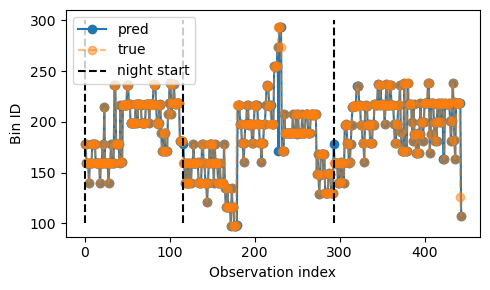

In [68]:
target_sequence = dataset.actions.detach().numpy()
eval_sequence = eval_actions
mask_first_obs = dataset.states[:, 0] == 0. 

fig, axs = plt.subplots(1, figsize=(5,3))
axs.plot(eval_sequence, marker='o', label='pred')
axs.plot(target_sequence, marker='o', linestyle='dashed', label='true', alpha=.5)
axs.set_xlabel('Observation index')
axs.set_ylabel('Bin ID')
axs.vlines(first_obs_in_night_indices, ymin=100, ymax=300, linestyle='--', color='black', label='night start')
axs.legend()

# axs[1].plot(eval_sequence - target_sequence, marker='o')
# axs[1].legend()
# axs[1].set_xlabel('obs index')
# axs[1].set_ylabel('pred - true')

fig.tight_layout()
fig.savefig(fig_outdir + 'learned_sequence.png')

In [ ]:
# oct/nov of 2014